<a href="https://colab.research.google.com/github/owlmt/QuantumCybersecurityAnalytics/blob/main/GWU_CyberSecurity_Analytics_Course_8414_Unsupervised_Learning_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Step 1: Install Dependencies
!pip install scikit-learn pandas numpy clang tqdm

In [ ]:
#  Step 2: Download and Unzip Juliet Test Suite
import os
import zipfile
import urllib.request

# Define the dataset URL
dataset_url = "https://samate.nist.gov/SARD/downloads/test-suites/2017-10-01-juliet-test-suite-for-c-cplusplus-v1-3.zip"
dataset_zip = "juliet_dataset.zip"
dataset_folder = "juliet_dataset"

# Download the dataset if not already downloaded
if not os.path.exists(dataset_zip):
    print("Downloading Juliet Test Suite...")
    urllib.request.urlretrieve(dataset_url, dataset_zip)

# Unzip the dataset
if not os.path.exists(dataset_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)

print("Dataset is ready!")



Dataset is ready!


In [ ]:
#  Step 3: Load Dataset
def load_dataset(dataset_path):
    """
    Loads the Juliet Test Suite dataset for CWE-121 Stack-Based Buffer Overflow.

    Parameters:
        dataset_path (str): Path to the CWE-121 folder inside Juliet Test Suite.

    Returns:
        data (list): List of C/C++ code snippets.
        labels (list): List of labels (1 = vulnerable, 0 = safe).
    """
    data = []
    labels = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".c") or file.endswith(".cpp"):
                with open(os.path.join(root, file), 'r', encoding='utf-8', errors='ignore') as f:
                    code = f.read()
                    data.append(code)
                    # Label: If filename contains "bad", it's vulnerable (1), else safe (0)
                    labels.append(1 if "bad" in file else 0)

    return data, labels

# Define the dataset path for CWE-121 Stack-Based Buffer Overflow
dataset_path = os.path.join(dataset_folder, "C/testcases/CWE121_Stack_Based_Buffer_Overflow")

# Load the dataset
data, labels = load_dataset(dataset_path)

# Print dataset stats
print(f"Total code samples: {len(data)}")
print(f"Vulnerable samples: {sum(labels)}")
print(f"Safe samples: {len(labels) - sum(labels)}")

#  Step 4: Feature Extraction
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# List of unsafe C functions
UNSAFE_FUNCTIONS = ["gets", "strcpy", "strcat", "sprintf", "vsprintf", "scanf", "sscanf", "fscanf", "strncpy", "memcpy", "memmove"]

# Extract features from C/C++ code
def extract_features(code):
    features = {}

    # Count unsafe functions
    for func in UNSAFE_FUNCTIONS:
        features[f'count_{func}'] = len(re.findall(r'\b' + func + r'\b', code))

    # Count total function calls
    features['num_function_calls'] = len(re.findall(r'\b\w+\s*\(', code))

    # Count loop constructs
    features['num_loops'] = len(re.findall(r'\b(for|while|do)\b', code))

    # Count pointer usage
    features['num_pointers'] = len(re.findall(r'\*', code))

    # Count array indexing
    features['num_array_access'] = len(re.findall(r'\[.*?\]', code))

    return features

# Convert dataset to feature vectors using tqdm for progress tracking
print("Extracting features...")
feature_vectors = [extract_features(code) for code in tqdm(data)]
df = pd.DataFrame(feature_vectors)

#  Step 5: Train a Machine Learning Model
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

# Train the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

#  Step 6: Evaluate Model Performance
print("\n Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Total code samples: 7889
Vulnerable samples: 306
Safe samples: 7583
Extracting features...


100%|██████████| 7889/7889 [00:07<00:00, 1109.16it/s]



🔍 Model Performance:
Accuracy: 0.9480
Precision: 0.3875
Recall: 0.4844
F1 Score: 0.4306


In [ ]:
import joblib

# Save the trained model to a file
model_filename = "buffer_overflow_model.pkl"
joblib.dump(clf, model_filename)

print(f"Model saved as {model_filename}")


Model saved as buffer_overflow_model.pkl


In [ ]:
c_code = r'''
#include <stdio.h>
#include <string.h>

void vulnerableFunction(char *input) {
    char buffer[10]; // Fixed-size buffer
    strcpy(buffer, input); // No bounds checking (unsafe!)
    printf("You entered: %s\n", buffer);
}

int main() {
    char userInput[50];
    printf("Enter input: ");
    gets(userInput); // Unsafe function (deprecated)
    vulnerableFunction(userInput);
    return 0;
}

'''

In [ ]:
# Load Model and Test on Sample Code
clf_loaded = joblib.load("buffer_overflow_model.pkl")
sample_features = extract_features(c_code)
df_sample = pd.DataFrame([sample_features])
prediction = clf_loaded.predict(df_sample)[0]
prediction_prob = clf_loaded.predict_proba(df_sample)[0]
result = "VULNERABLE" if prediction == 1 else "SAFE"

print("Prediction for the sample C code:")
print(f"Model Prediction: {result}")
print(f"Prediction Probabilities: {prediction_prob}")


Prediction for the sample C code:
Model Prediction: SAFE
Prediction Probabilities: [0.83837675 0.16162325]


This means that:

The model is 83% confident that the code is safe.

The model is 16% confident that the code is vulnerable.

Not better than (if not worse)

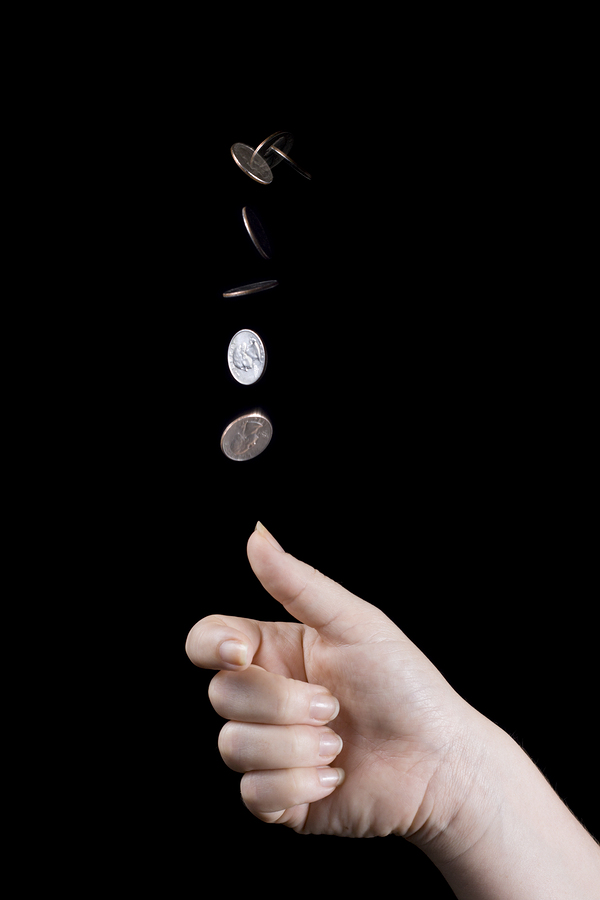

K-Mean

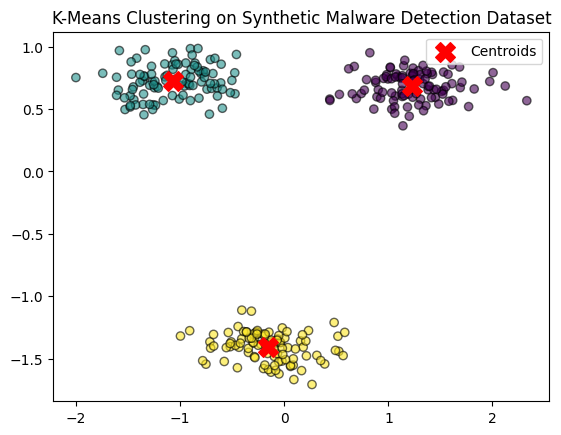

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

# Step 1: Generate synthetic dataset for malware detection
# Simulating Domain Generation Algorithm (DGA) and benign domain names
n_samples = 300
n_features = 5
n_clusters = 3  # Simulating 3 types of domain behavior

# Generate synthetic features
X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

# Step 2: Normalize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# Step 4: Visualize clustering results (Using first two features for plotting)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title("K-Means Clustering on Synthetic Malware Detection Dataset")
plt.legend()
plt.show()

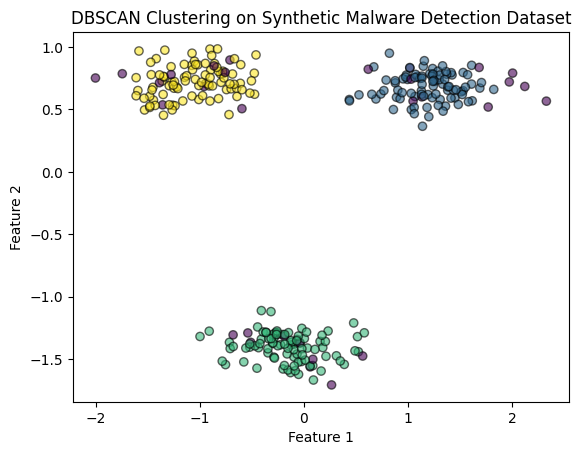

Estimated number of clusters: 3
Estimated number of noise points: 30


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

# Step 1: Generate synthetic dataset for malware detection
# Simulating Domain Generation Algorithm (DGA) and benign domain names
n_samples = 300
n_features = 5
n_clusters = 3  # Simulating 3 types of domain behavior

# Generate synthetic features
X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

# Step 2: Normalize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan.fit(X_scaled)
cluster_labels = dbscan.labels_

# Step 4: Visualize clustering results (Using first two features for plotting)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='k')
plt.title("DBSCAN Clustering on Synthetic Malware Detection Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Print the number of clusters and noise points
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Distance calculations for (2,2):
Distance to [1 2]: 1.00 (Neighbor)
Distance to [2 2]: 0.00 (Neighbor)
Distance to [2 3]: 1.00 (Neighbor)
Distance to [8 8]: 8.49 (Not a Neighbor)
Distance to [8 9]: 9.22 (Not a Neighbor)
Distance to [25 30]: 36.24 (Not a Neighbor)

DBSCAN Results:
Estimated number of clusters: 2
Estimated number of noise points: 1


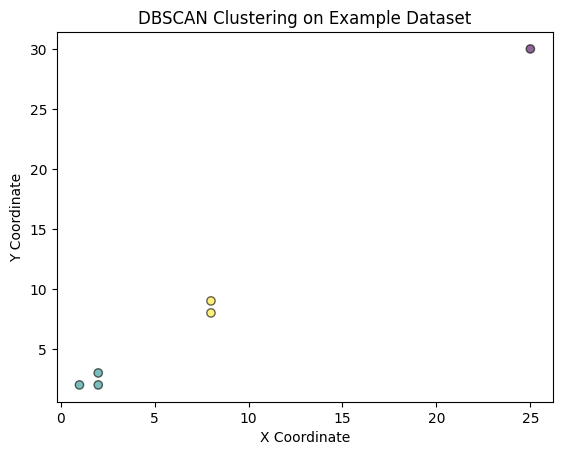

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import euclidean

# Step 1: Define dataset (same as our mathematical example)
points = np.array([
    [1, 2],  # Point A
    [2, 2],  # Point B
    [2, 3],  # Point C
    [8, 8],  # Point D
    [8, 9],  # Point E
    [25, 30] # Outlier
])

# Step 2: Apply DBSCAN with ε=2.0 and MinPts=2
dbscan = DBSCAN(eps=2.0, min_samples=2)
dbscan.fit(points)
cluster_labels = dbscan.labels_

# Step 3: Print Distance Calculations for (2,2)
point_of_interest = np.array([2, 2])
print("Distance calculations for (2,2):")
for i, point in enumerate(points):
    dist = euclidean(point_of_interest, point)
    print(f"Distance to {point}: {dist:.2f} {'(Neighbor)' if dist <= 2.0 else '(Not a Neighbor)'}")

# Step 4: Print Cluster Assignments
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print("\nDBSCAN Results:")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Step 5: Visualize clustering results
plt.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='k')
plt.title("DBSCAN Clustering on Example Dataset")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


Original Data:
[[2 4]
 [3 6]
 [4 8]]

Standardized Data:
[[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]

Transformed Data (1D Representation):
[[-1.73205081]
 [ 0.        ]
 [ 1.73205081]]


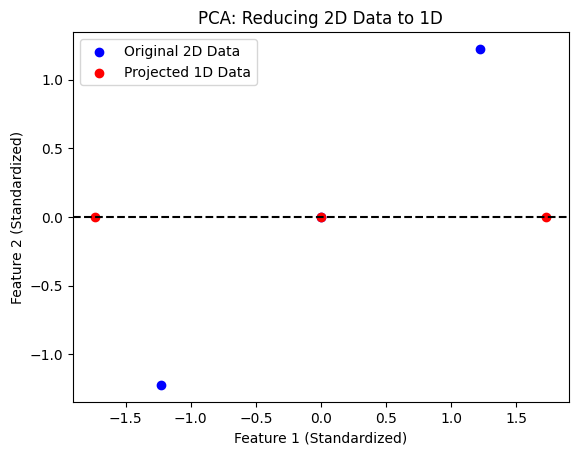

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Define the dataset (3 samples, 2 features)
X = np.array([
    [2, 4],  # Point A
    [3, 6],  # Point B
    [4, 8]   # Point C
])

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA to reduce from 2D to 1D
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Print transformed dataset
print("Original Data:")
print(X)
print("\nStandardized Data:")
print(X_scaled)
print("\nTransformed Data (1D Representation):")
print(X_pca)

# Step 5: Visualize the transformation
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], label='Original 2D Data', color='blue')
plt.scatter(X_pca, np.zeros_like(X_pca), label='Projected 1D Data', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.title("PCA: Reducing 2D Data to 1D")
plt.legend()
plt.show()

Original Log Data (First 5 Rows):
    Time_Diff  Failed_Logins  Machines_Accessed  Priv_Escalation
0  11.236204       9.507143           3.659970         1.795975
1   4.680559       1.559945           0.290418         2.598528
2  18.033450       7.080726           0.102922         2.909730
3  24.973279       2.123391           0.909125         0.550214
4   9.127267       5.247564           2.159725         0.873687


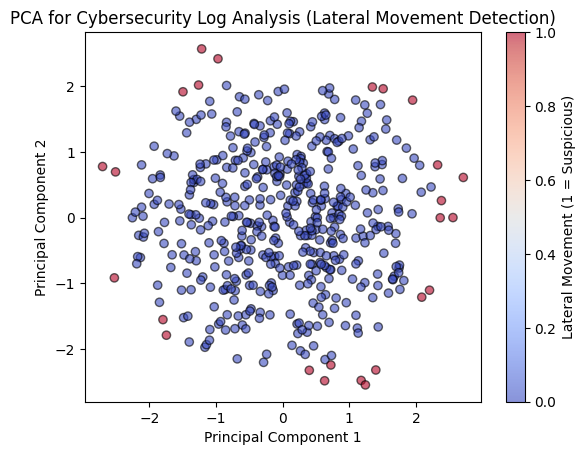


Potential Lateral Movement Cases:
           PC1       PC2  Anomaly_Score  Lateral_Movement
8    1.176827 -2.475992       2.741434              True
45   2.362347 -0.003261       2.362349              True
61   0.399242 -2.322117       2.356188              True
78   0.628988 -2.481233       2.559716              True
118  0.722637 -2.241359       2.354972              True


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Generate synthetic log data for cybersecurity (Lateral Movement Detection)
np.random.seed(42)
n_samples = 500

# Simulating log features:
# - Time difference between authentication events
# - Number of failed login attempts
# - Number of machines accessed in a short time
# - Frequency of privilege escalation commands
X = np.random.rand(n_samples, 4) * [30, 10, 5, 3]  # Scaling different features

# Convert to DataFrame for better understanding
df = pd.DataFrame(X, columns=["Time_Diff", "Failed_Logins", "Machines_Accessed", "Priv_Escalation"])
print("Original Log Data (First 5 Rows):\n", df.head())

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA to reduce from 4D to 2D for better analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Convert PCA result into DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Anomaly_Score"] = np.linalg.norm(X_pca, axis=1)  # Compute anomaly score

# Step 5: Identify potential lateral movement signs
threshold = np.percentile(pca_df["Anomaly_Score"], 95)  # Top 5% most anomalous activities
pca_df["Lateral_Movement"] = pca_df["Anomaly_Score"] > threshold

# Step 6: Visualize PCA-transformed log data
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["Lateral_Movement"], cmap='coolwarm', alpha=0.6, edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA for Cybersecurity Log Analysis (Lateral Movement Detection)")
plt.colorbar(label="Lateral Movement (1 = Suspicious)")
plt.show()

# Print detected lateral movement cases
print("\nPotential Lateral Movement Cases:\n", pca_df[pca_df["Lateral_Movement"]].head())
